In [25]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [26]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=4, random_state=0)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 4) (200, 4) (800,) (200,)


In [28]:
x1_train = [X_train[i] for i in range(len(X_train)) if y[i] == 0]
x2_train = [X_train[i] for i in range(len(X_train)) if y[i] == 1]

x1_train = np.array(x1_train)
x2_train = np.array(x2_train)

In [29]:
x1_test = [X_test[i] for i in range(len(X_test)) if y[i] == 0]
x2_test = [X_test[i] for i in range(len(X_test)) if y[i] == 1]

x1_test = np.array(x1_test)
x2_test = np.array(x2_test)

In [31]:
# size of training data set
training_size = 800
test_size = 200
# dimension of data sets
n = 2
training_input = {'A':x1_train, 'B':x2_train}
test_input = {'A':x1_test, 'B':x2_test}
class_labels = ['A', 'B']
sv = Statevector.from_label('0' * n)

In [32]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        circuit.ry(params[i], i)
    circuit.cx(0,1)

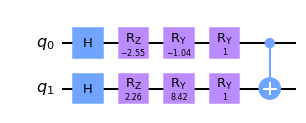

In [33]:
cir = QuantumCircuit(2)
final_circuit(cir, x1_train[0],[1,1])
cir.draw('mpl')

In [46]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 2  # num of trainable params
for i in range(5):
    np.random.seed(i)
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Data/1Layer/Layer1Easy/quantum_loss_easy_layer1blobs1000_%d.npy' %i
    f2 = 'Data/1Layer/Layer1Easy/opt_params_easy_layer1blobs1000_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[0.09762701 0.43037873]
[0.9153482717635123, 0.9114919109089012, 0.9063439137502036, 0.9015099599995993, 0.8976945067396922, 0.8963706236123555, 0.8959806551352786, 0.8932298229885894, 0.8920372504051164, 0.8945106746131084, 0.8967264003523884, 0.8969540137094418, 0.8958115353183449, 0.8937443783406485, 0.8922281151823044, 0.8919800543438111, 0.8927887449399958, 0.8937815342700287, 0.8942276578604432, 0.8939903934608661, 0.8932425486260885, 0.8924054507779177, 0.8919427408313066, 0.8920433482280389, 0.8925108603971439, 0.8929289413035142, 0.8929867399103943, 0.8926770965016699, 0.8922386207160818, 0.8919512171239623, 0.8919517215172139, 0.8921645649966189, 0.892387308044587, 0.8924506142360221, 0.8923225628142126, 0.8921039123927436, 0.8919426090149233, 0.8919286657509784, 0.8920363378428986, 0.892154994746431, 0.8921835578672987, 0.8921057817157825, 0.8919889118676515, 0.8919195423432889, 0.8919346385065567, 0.8920008324688249, 0.8920517093006103, 0.8920445115295447, 0.891989318308587

In [35]:
opt_params = np.load('Data/1Layer/Layer1Easy/opt_params_easy_layer1blobs1000_0.npy')

In [36]:
cost = cost_function(test_input, class_labels, opt_params)

In [37]:
cost

0.9436361359077696

In [39]:
loss = np.load('Data/1Layer/Layer1Easy/quantum_loss_easy_layer1blobs1000_0.npy')

ValueError: x and y must have same first dimension, but have shapes (1000,) and (100,)

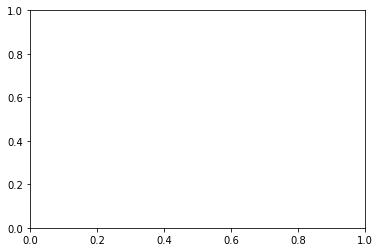

In [45]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(1000), loss)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 1 Layer (Data Reuploading, Qubits = 2, Easy Model, Blobs)")

In [42]:
sd = np.std(loss, axis=0)

In [43]:
sd

0.0035480867438742545